
  <div align="center" textsize="30">
  <font size="10">
    Notebook for training microteks models

</div>

# 1.Setup

This notebook is used to train the model using yolov5 model family after getting the images datasets, making data augmenation if needed, spliting the dataset in three folders (Train, validation and test). After training the model using the paramters (imagesize, batch, epochs), the resulting metrics are evaluated and sent to MLFLOW after making some modification in train.py file inside yolov5 folder. If the model accuracy are satified, it will be ready to be deployed in production. In addition, the Carbon emission metric is computed using Codecarbon library to track CO2 emssions and power consumption.

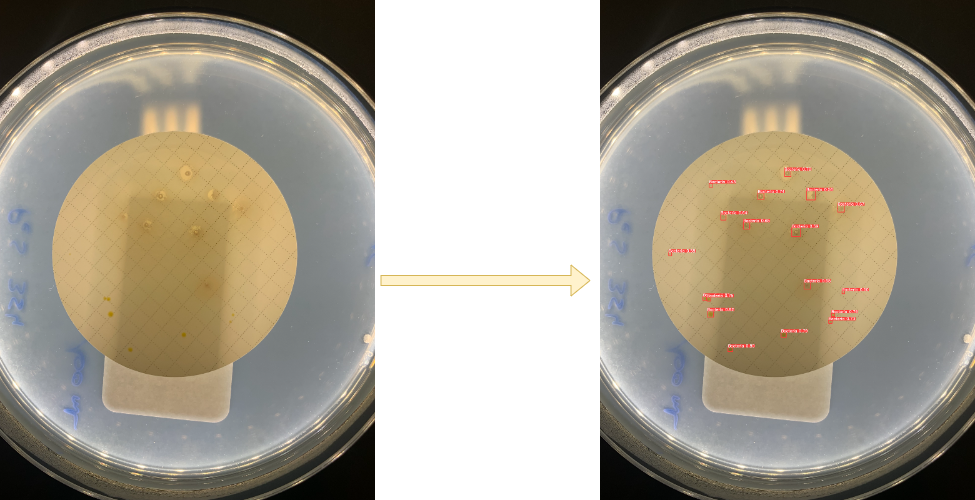

### Mount Google Drive storage

In [1]:
#mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive


/
Mounted at /content/gdrive


### Change working directory


In [2]:
import os
BASEDIR = "/content/gdrive/My Drive/04-Projets/01-ML/LABOAI/"
DATADIR = 'L4_U1'
DataPath =  os.path.join(BASEDIR, DATADIR)
os.chdir(DataPath)

### Clone yolov5 repository and install requirements

In [2]:
cd yolov5

d:\01-Projects\CAT\MyCode\1-POC\yolov5


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
%cd yolov5
%pip install -qr requirements.txt  

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install



YOLOv5 🚀 2022-11-25 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 23.1/166.8 GB disk)


### Import dependencies

In [38]:
import torch
import utils
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

# 2. Data preparation and preprocessing


### Image counting

In [20]:
%cd Data

/content/gdrive/MyDrive/04-Projets/01-ML/LABOAI/L4_U1/Data


In [24]:
import os
# List of supported image file extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
total_images = 0
for root_dir, cur_dir, files in os.walk(r'images'):
  for file in files:
    if file.lower().endswith(image_extensions):
      total_images += 1

print('file count:', total_images)

file count: 219


### Visualize images samples

In [30]:
def visualize_random_images(dataset_dir, num_images=6):
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    # Collect all image file paths from the dataset directory
    all_images = [os.path.join(dataset_dir, img) for img in os.listdir(dataset_dir) if img.endswith(image_extensions)]

    # Randomly select the specified number of images
    selected_images = random.sample(all_images, num_images)

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = imread(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

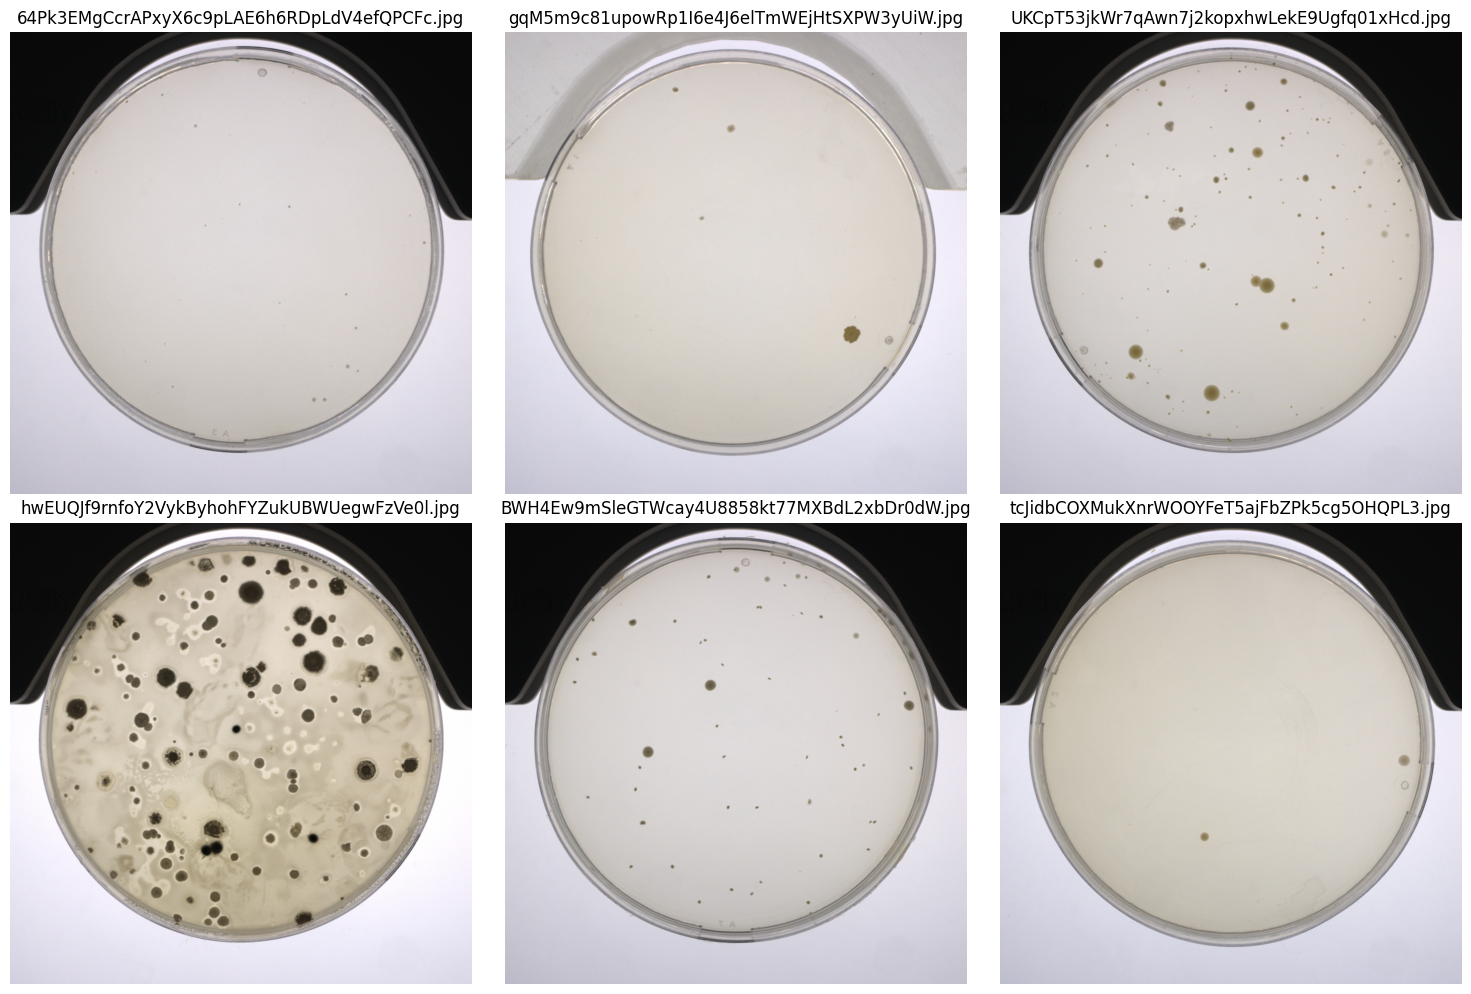

In [13]:
#  Display some images
dataset_directory = 'Data/images/train'  # Replace with your dataset directory path
visualize_random_images(dataset_directory)


### Data augumentation

In [ ]:
# clone yolo-data-augmentation repository
!git clone https://github.com/muhammad-faizan-122/yolo-data-augmentation.git

In [14]:
%cd yolo-data-augmentation/

/content/gdrive/MyDrive/04-Projets/01-ML/LABOAI/L4_U1/yolo-data-augmentation


In [17]:
# install requirments
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


In [18]:
# View data augmentation setting
!cat contants.yaml

inp_img_pth : ../Data_in/images
inp_lab_pth : ../Data_in/labels
out_img_pth : ../Data_out/images
out_lab_pth : ../Data_out/labels
transformed_file_name : aug_out_3
CLASSES : ['Aspergillus niger']


In [ ]:
# run data augmentation process
!python3 main.py

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


### Split Dataset

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]
# Sort images
images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

### Creating subdirectories

In [ ]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

### Move images to directories (Train, Validation, Test)

In [ ]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
%cd /content/gdrive/My Drive/04-Projets/01-ML/LABOAI/L2_U1_MLFLOW/yolov5

/content/gdrive/My Drive/04-Projets/01-ML/LABOAI/L2_U1_MLFLOW/yolov5


# 3. Train The model

The model will be trained using the given parameters, the metrics, parameters and artifacts (weights) will be send to MLFLOW in the modified train.py file inside yolov5 folder

### Setup environment variables

In [ ]:
# Set CLIENT and USECASE as environment variables
os.environ["CLIENT"] = "NATURA_CHIMICA"
os.environ["USECASE"] = "BACTERIA2_NAC"
UC_Folder = os.getenv("USECASE")

### Training the model

In [ ]:
# Train YOLOv5m (medium) on our data for 500 epochs, 10 batch and 1280 image size
!python train.py --img 1280 --batch 10 --epochs 500 --data ../Data/data_{UC_Folder}.yaml --weights yolov5m.pt --cache --patience 0

Streaming output truncated to the last 5000 lines.
##### log_vals [tensor(0.05097, device='cuda:0'), tensor(0.16271, device='cuda:0'), tensor(0., device='cuda:0'), 0.666805958234426, 0.44366197183098594, 0.46117132448210807, 0.19719629057464444, 0.05456357076764107, 0.17557525634765625, 0.0, 0.006574600000000001, 0.006574600000000001, 0.006574600000000001]
##### last runs/train/exp50/weights/last.pt
##### final_epoch False
##### best_fitness [    0.22359]
##### fi [    0.22359]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    175/499      16.1G    0.05078     0.1758          0       1099       1280:  75% 6/8 [00:03<00:01,  1.72it/s][codecarbon INFO @ 10:06:04] Energy consumed for RAM : 0.011773 kWh. RAM Power : 23.55161762237549 W
[codecarbon INFO @ 10:06:04] Energy consumed for all GPUs : 0.025509 kWh. Total GPU Power : 43.791486257736466 W
[codecarbon INFO @ 10:06:04] Energy consumed for all CPUs : 0.021251 kWh. Total CPU Power : 42.5 W
[codecarbon I

### Display Mterics (Loss, Accuracy)

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def generate_metrics_charts(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Define metrics to plot
    loss_metrics = [
        "train/box_loss", "train/obj_loss", "train/cls_loss",
        "val/box_loss", "val/obj_loss", "val/cls_loss"
    ]
    accuracy_metrics = [
        "metrics/precision", "metrics/recall", "metrics/mAP_0.5",
        "metrics/mAP_0.5:0.95"
    ]

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Losses', 'Training and Validation Accuracy Metrics'))

    # Add loss metrics to the first subplot
    for metric in loss_metrics:
        fig.add_trace(go.Scatter(x=df['epoch'], y=df[metric], mode='lines', name=metric), row=1, col=1)

    # Add accuracy metrics to the second subplot
    for metric in accuracy_metrics:
        fig.add_trace(go.Scatter(x=df['epoch'], y=df[metric], mode='lines', name=metric), row=1, col=2)

    # Update layout for the first subplot (loss metrics)
    fig.update_yaxes(title_text="Loss Value", range=[0, 1], row=1, col=1)
    fig.update_xaxes(title_text="Epoch", row=1, col=1)

    # Update layout for the second subplot (accuracy metrics)
    fig.update_yaxes(title_text="Metric Value", row=1, col=2)
    fig.update_xaxes(title_text="Epoch", row=1, col=2)

    # Set the layout title
    fig.update_layout(title_text="Training and Validation Metrics Over Epochs")

    # Show the plot
    fig.show()





In [ ]:
# Display metrics
csv_file_path = 'runs/train/exp/results.csv'  # Replace with the correct file path
generate_metrics_charts(csv_file_path)

### Mlflow

The metrics and artifat of this experiment run will be tracked by MLflow

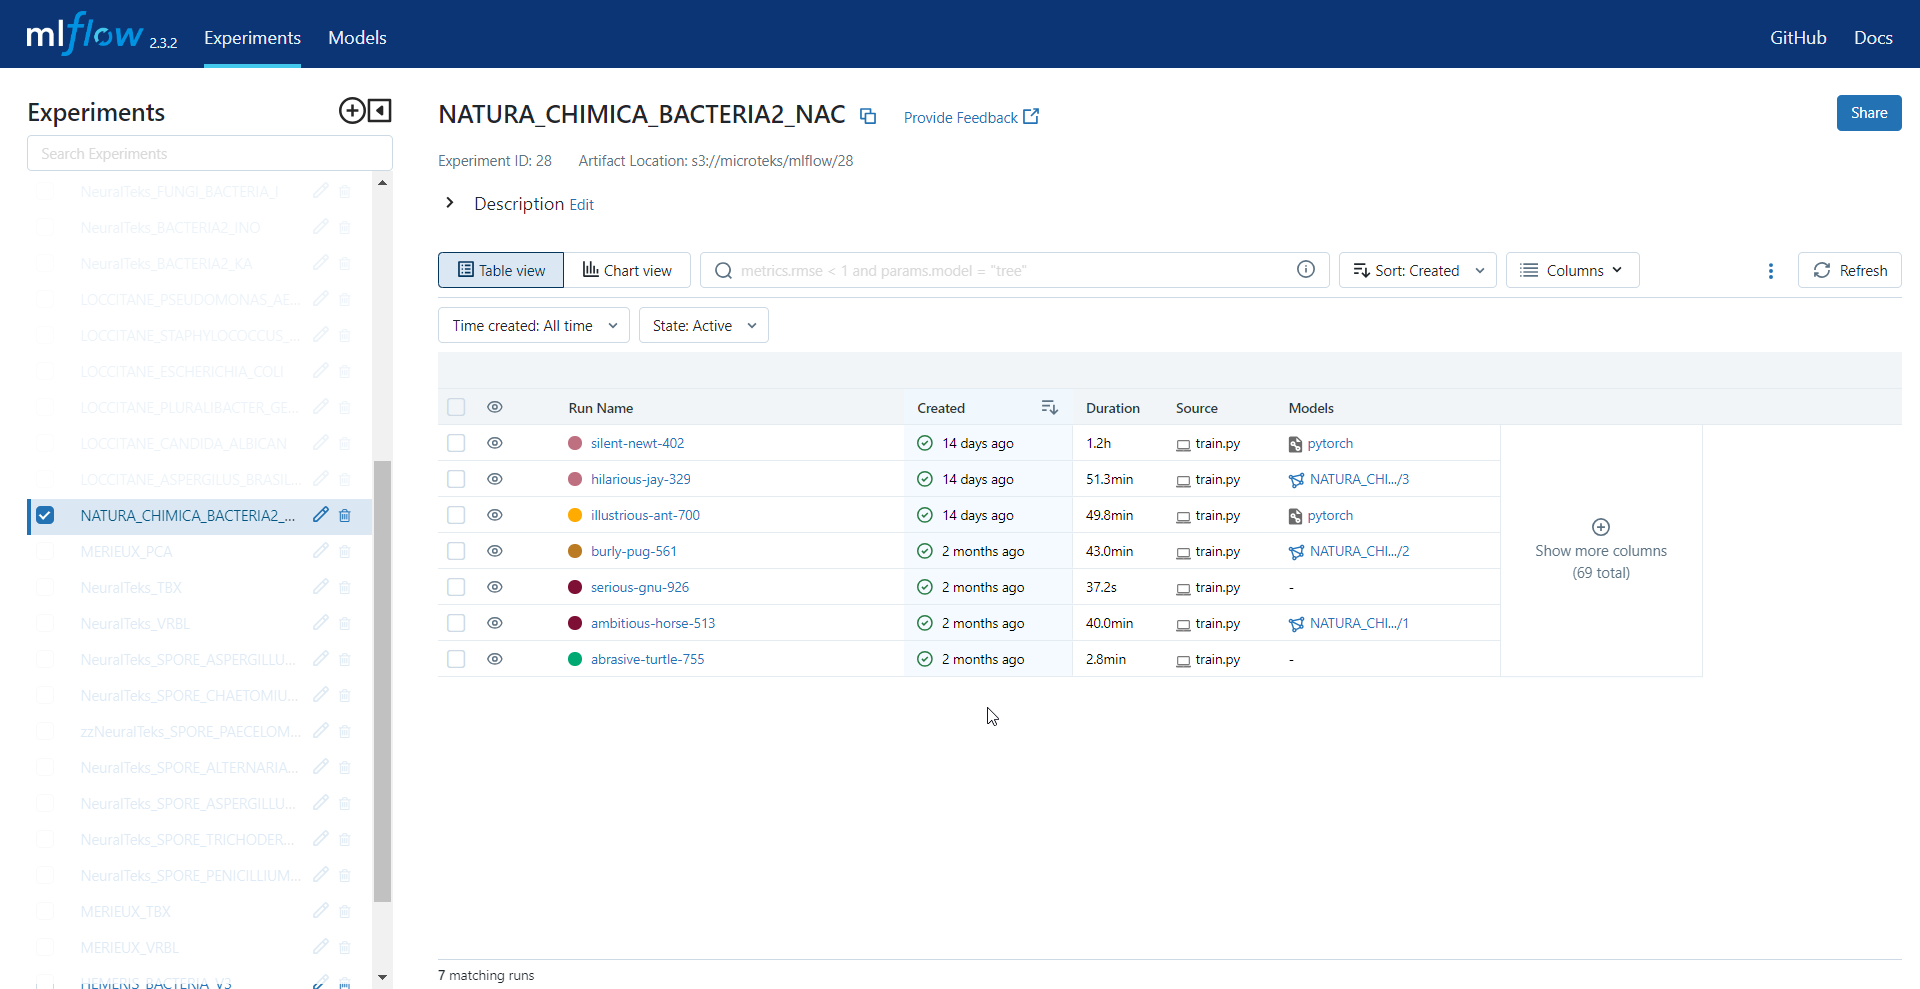

# 4. Detection

In [35]:
!python detect.py --weights ./runs/train/exp/weights/best.pt --img 1280 --conf 0.5 --source ../Data/images/test

detect: weights=['./runs/train/exp/weights/best.pt'], source=../Data/images/test, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 269.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.4s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 227

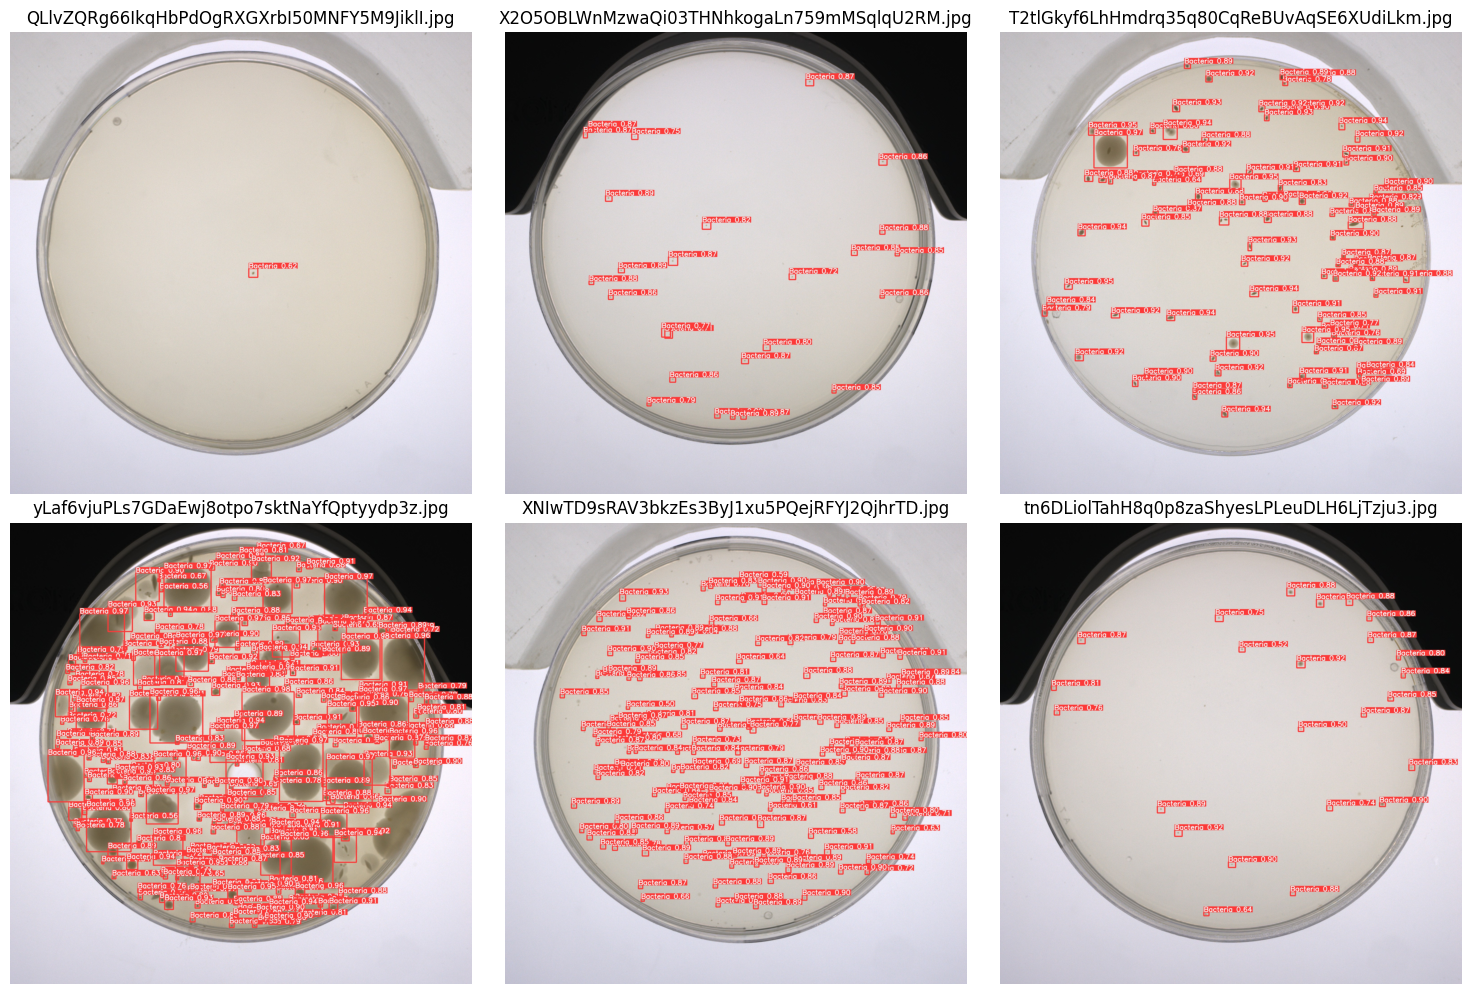

In [39]:
# Display some dtected images
detection_directory = 'runs/detect/exp'  # Replace with your dataset directory path
visualize_random_images(detection_directory)